<a href="https://colab.research.google.com/github/Olney1/Deploying-a-Neural-Network-Model-with-Flask/blob/master/Image_Classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install fastai
!pip install duckduckgo-search
from fastai.vision.all import *
from fastai.vision.widgets import *
from fastdownload import download_url

In [ ]:
from duckduckgo_search import ddg_images
from fastcore.all import *

def search_images(term, max_images=30):
    print(f"Searching for '{term}'")
    return L(ddg_images(term, max_results=max_images)).itemgot('image')

In [ ]:
urls = search_images('pigeon', max_images=2)
urls[0]

Searching for 'pigeon'


'http://www.aceco-extermination.com/wp-content/uploads/2015/02/pigeon.jpg'

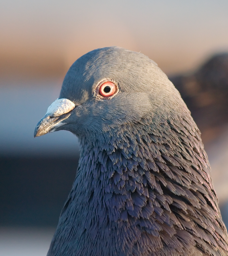

In [ ]:
dest = 'pigeon.jpg'
download_url(urls[1], dest, show_progress=False)


im = Image.open(dest)
im.to_thumb(256,256)

If you want second images for testing later that you have found directly online, you can do the following:

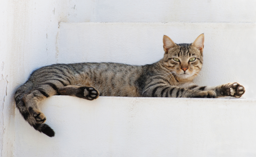

In [ ]:
cat_url = ('https://upload.wikimedia.org/wikipedia/commons/1/15/Cat_August_2010-4.jpg')
dest2 = 'cat.jpg'
download_url(cat_url, dest2, show_progress=False)
im = Image.open(dest2)
im.to_thumb(256,256)

Searching for 'dog'


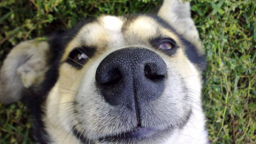

In [ ]:
dest = 'dog.jpg'
download_url(search_images('dog', max_images=2)[1], dest, show_progress=False)
Image.open('dog.jpg').to_thumb(256,256)

Searching for 'human'


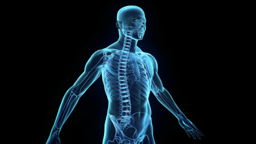

In [ ]:
dest = 'human.jpg'
download_url(search_images('human', max_images=2)[0], dest, show_progress=False)
Image.open('human.jpg').to_thumb(256,256)

Searching for 'baby'


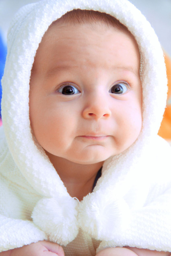

In [ ]:
dest = 'baby.jpg'
download_url(search_images('baby', max_images=2)[0], dest, show_progress=False)
Image.open('baby.jpg').to_thumb(256,256)

# Training the model

## Search for the images to use in our dataset

In [ ]:
searches = 'dog','pigeon','human','baby','cat'
path = Path('garden_vision')
from time import sleep

for o in searches:
    dest = (path/o)
    dest.mkdir(exist_ok=True, parents=True)
    download_images(dest, urls=search_images(f'{o} photo'))
    #sleep(10)  # Pause between searches to avoid over-loading server
    #download_images(dest, urls=search_images(f'{o} in the morning'))
    #sleep(10)
    #download_images(dest, urls=search_images(f'{o} in the dark'))
    #sleep(10)
    resize_images(path/o, max_size=400, dest=path/o)

Searching for 'dog photo'
Searching for 'pigeon photo'
Searching for 'human photo'
Searching for 'baby photo'
Searching for 'cat photo'


In [ ]:
failed = verify_images(get_image_files(path))
failed.map(Path.unlink)
len(failed)

3

## To train a model, we'll need DataLoaders, which is an object that contains a training set (the images used to create a model) and a validation set (the images used to check the accuracy of a model -- not used during training). In fastai we can create that easily using a DataBlock, and view sample images from it:

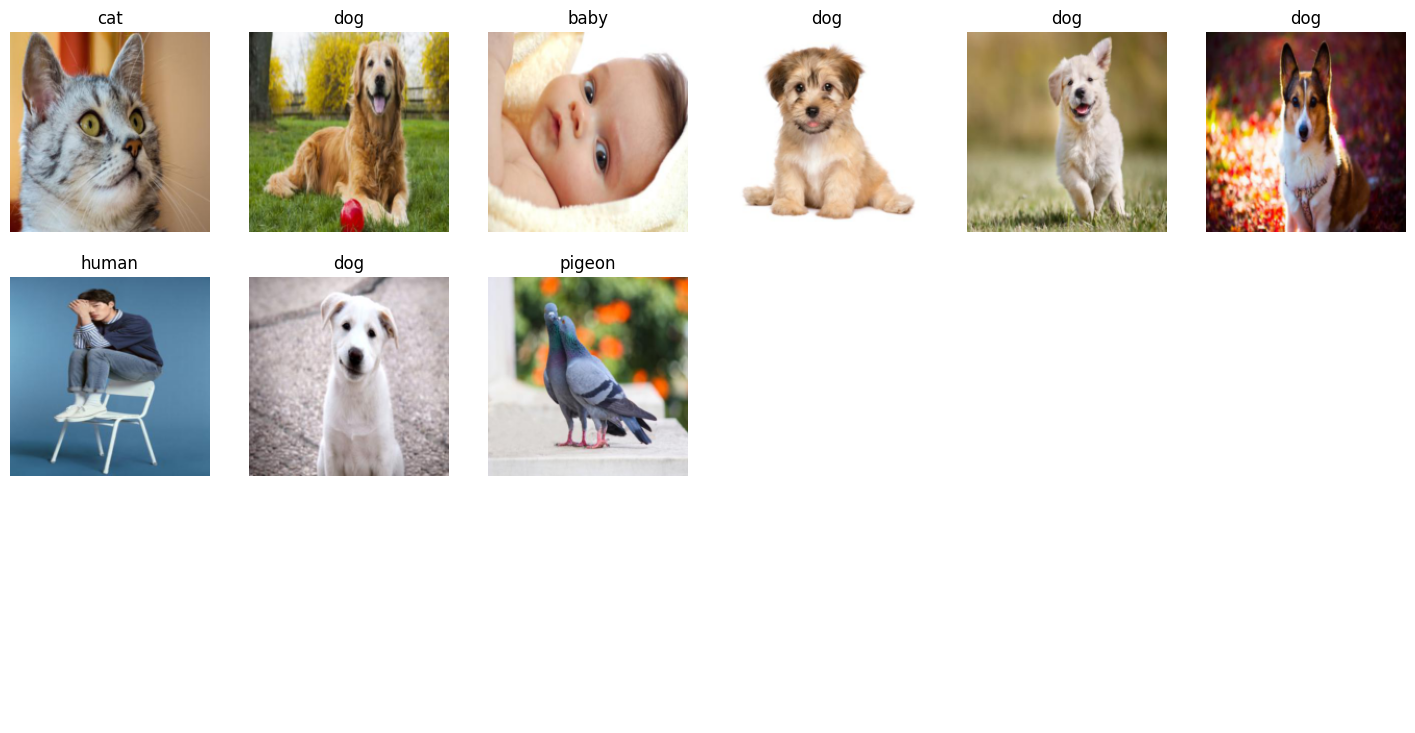

In [ ]:
dls = DataBlock(
    blocks=(ImageBlock, CategoryBlock),
    get_items=get_image_files,
    splitter=RandomSplitter(valid_pct=0.2, seed=42),
    get_y=parent_label,
    item_tfms=[Resize(192, method='squish')]
).dataloaders(path, bs=32)

dls.show_batch(nrows=3, ncols=3)

## Now we're ready to train our model. The fastest widely used computer vision model is resnet18.

## fastai comes with a helpful fine_tune() method which automatically uses best practices for fine tuning a pre-trained model, so we'll use that.

In [ ]:
learn = vision_learner(dls, resnet18, metrics=error_rate)
learn.fine_tune(3)

## Below we check for confusion using the Confusion matrix which shows where predictions made actually turned out to be wrong.

In general, a model where the predicted class matches the actual class more frequently (that is, higher true positive and true negative rates) is a better performing model. The aim of any supervised learning model is to make predictions that align with the ground truth as closely as possible.

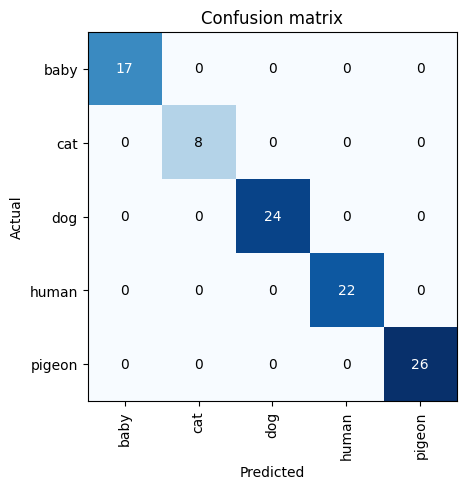

In [ ]:
interp = ClassificationInterpretation.from_learner (learn)
interp.plot_confusion_matrix()

## Below is a cool tool that measures how good our model is further, for example how confident our model is, either confidently wrong or unconfidently right.

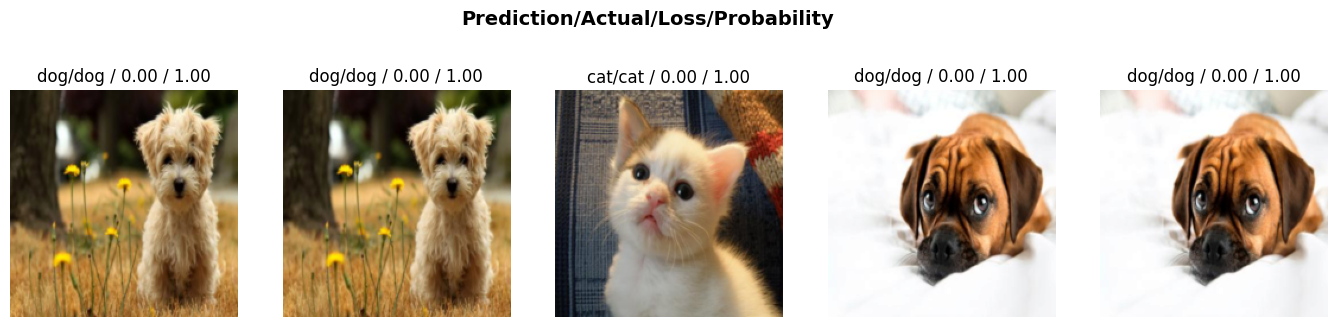

In [ ]:
interp.plot_top_losses (5, nrows=1, figsize=(17,4))

## Now we can look at our dataset at the 'highest loss' images in order to clean up our 'training' and 'validation' datasets to remove images that are incorrectly labelled or assign images to the right label.

### First we double check the location and number of images before we clean:

In [ ]:
cleaner = ImageClassifierCleaner(learn)
cleaner.fns

(#30) [Path('garden_vision/baby/30eccae1-d2f2-40d6-88a7-c863f9efc1df.jpg'),Path('garden_vision/baby/faba13de-6baf-418b-9109-d4d07793656b.jpg'),Path('garden_vision/baby/c71f2b82-e328-472e-b357-719a84e823b5.jpg'),Path('garden_vision/baby/c95a421d-f5dc-4758-abfc-38f027d4b0b9.jpg'),Path('garden_vision/baby/f544bd70-2b16-4bed-ab32-e41381598577.jpg'),Path('garden_vision/baby/136d5c4d-cda6-4c4c-8682-a92ecf3a638a.jpg'),Path('garden_vision/baby/155f0362-63ee-468c-8dda-b768de2ddaed.jpg'),Path('garden_vision/baby/d2c51a36-76b1-44ec-afa6-c9654eb82e79.jpg'),Path('garden_vision/baby/54375518-0cb3-48fa-b867-72b79c52a564.jpg'),Path('garden_vision/baby/f8f1e3f4-1a8c-466b-b3b7-ab5250c09c57.jpg')...]

In [ ]:

cleaner

## Now we process the cleaning we have selected from above

In [ ]:
for idx in cleaner.delete (): cleaner.fns[idx].unlink()

### Now to check the location and number of images after the clean (to ensure it worked):

In [ ]:
cleaner.fns

(#30) [Path('garden_vision/baby/30eccae1-d2f2-40d6-88a7-c863f9efc1df.jpg'),Path('garden_vision/baby/faba13de-6baf-418b-9109-d4d07793656b.jpg'),Path('garden_vision/baby/c71f2b82-e328-472e-b357-719a84e823b5.jpg'),Path('garden_vision/baby/c95a421d-f5dc-4758-abfc-38f027d4b0b9.jpg'),Path('garden_vision/baby/f544bd70-2b16-4bed-ab32-e41381598577.jpg'),Path('garden_vision/baby/136d5c4d-cda6-4c4c-8682-a92ecf3a638a.jpg'),Path('garden_vision/baby/155f0362-63ee-468c-8dda-b768de2ddaed.jpg'),Path('garden_vision/baby/d2c51a36-76b1-44ec-afa6-c9654eb82e79.jpg'),Path('garden_vision/baby/54375518-0cb3-48fa-b867-72b79c52a564.jpg'),Path('garden_vision/baby/f8f1e3f4-1a8c-466b-b3b7-ab5250c09c57.jpg')...]

# Using the model on our own picture from the start

### probs[] is important here. When you predict with learn.predict(), it returns the probabilities for each class in the order of the class labels. If 'dog' is the first class and 'pigeon' is the second, probs[0] would give you the probability of the image being a 'dog', not a 'pigeon'. Check the order of your class labels with learn.dls.vocab.

In [ ]:
print(learn.dls.vocab)


['baby', 'cat', 'dog', 'human', 'pigeon']


### So now we can test the final model and check the probabilty with images we loaded at the start!


In [ ]:
pred_class,pred_idx,outputs = learn.predict('cat.jpg')
prediction = str(pred_class)

print(f"This is a {prediction}, Confidence level: {str(outputs[pred_idx.item()])}")

This is a cat, Confidence level: tensor(1.0000)


## Here we export the model in a pickle file ready for production!

In [ ]:
#learn.export('human_dog_pigeon_baby_model_v2.pkl')
